In [192]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()


from pixel_cnn  import train_pixel_cnn       
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images.shape
test_images.shape

import numpy as onp
train_images = onp.random.randint(0, 255, train_images.shape).astype('uint8')

# make some bimodal IID data
train_images = onp.where(onp.random.rand(*train_images.shape) > 0.5, 250, 5) + onp.random.normal(0, 10, train_images.shape)



In [195]:
# Generate gaussian mixture IID pixel values

import jax
from tqdm import tqdm
n_images = 8000
# image_size = train_images.shape[1]
image_size = 5

# Number of Gaussian components
n_components = 7

# Randomly generate means, std_devs, and weights
onp.random.seed(5)  # For reproducibility
means = onp.random.uniform(0, 255, n_components)
std_devs = onp.random.uniform(1, 50, n_components)
weights = onp.random.dirichlet(onp.ones(n_components), size=1).flatten()

# Initialize array to store images
images = []

# Vectorized image generation
for i in tqdm(range(n_images)):
    # Generate component indices based on weights
    component_indices = onp.random.choice(n_components, size=(image_size, image_size), p=weights)
    
    # Draw from Gaussians
    key = jax.random.PRNGKey(i)
    # pixel_values = onp.random.normal(means[component_indices], std_devs[component_indices])
    pixel_values = means[component_indices] + std_devs[component_indices] * jax.random.normal(key, shape=(image_size, image_size))
    
    # Clip to [0, 255]
    pixel_values = np.clip(pixel_values, 0, 255)
    
    images.append(pixel_values)

train_images = np.array(images)
train_images = np.where(train_images > 0, train_images, 0)


100%|██████████| 8000/8000 [00:15<00:00, 521.02it/s]


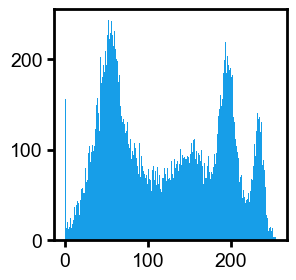

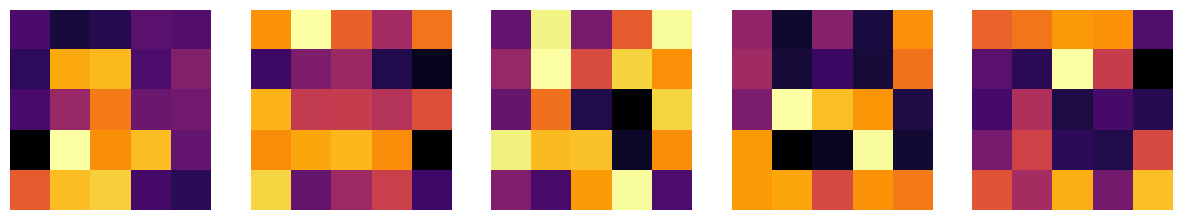

In [211]:
# histogram of pixel values
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.hist(train_images[:1000].flatten(), bins=256)

# plot a few images
fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    ax[i].imshow(train_images[i], cmap='inferno')
    ax[i].axis('off')

## Plot the distributions for each pixel

2023-10-17 11:33:49.535987: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-17 11:33:49.536016: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[128,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[128,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}


Initial validation NLL: 151.39


2023-10-17 11:34:00.602629: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:808] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.
2023-10-17 11:34:00.602661: W external/xla/xla/service/gpu/conv_algorithm_picker.cc:811] Conv: (f64[1,128,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f64[1,64,5,5]{3,2,1,0}, f64[128,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}


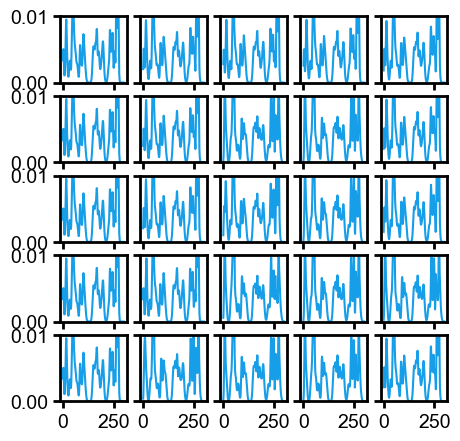

In [197]:
num = 5
# num = 28


pixel_cnn = PixelCNN()
pixel_cnn.fit(train_images, 
                            num_hidden_channels=64, num_mixture_components=40,
            max_epochs=0, steps_per_epoch=200, patience=10, batch_size=128, num_val_samples=1000, verbose=True)

# evaluate the probability at each pixel
y = np.linspace(-1, 258, 300).reshape(-1, 1, 1, 1, 1)
mu, sigma, log_mix = pixel_cnn._pixel_cnn_flax.forward_pass(train_images[:1][..., None])
nll = - logsumexp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True) + pixel_cnn._pixel_cnn_flax.lognormal(y, mu, sigma), axis=-1)

probs = np.exp(-nll[:, 0, :num, :num])
# probs = -nll[:, 0, :num, :num]

fig, ax = plt.subplots(num, num, figsize=(num, num), sharex=True, sharey=True)
for i in range(num):
    for j in range(num):
        ax[i,j].plot(probs[..., i, j])
        ax[i,j].set_ylim(0, 0.01)

        

In [6]:
mix = np.exp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True))
assert np.allclose(mix.sum(-1), 1)

mix[0, 0, 3, :]
mu[0, 0, 3, :]


sigma[0, 0, 3, :]

Array([ 25.84231545,   0.        ,  17.44116827,  24.25793894,
        75.01287698,  20.65723465,  63.94159878,   0.        ,
       155.84876462,  79.5756415 , 172.78562988, 158.59538796,
       139.06059287, 258.26475156, 219.5640879 ,  17.7028544 ,
       148.27527348, 131.86903923, 258.59662334, 263.25627975,
       254.10263028, 264.66224101,  31.61949067,  80.62911908,
       213.72079988, 234.2785413 , 183.82360532, 229.44607265,
         0.        , 244.29710402,  14.25132485, 142.21717142,
         0.        , 128.70998853, 225.3508243 , 254.116613  ,
       181.29644162,  41.78767191,   3.12696293,  57.27228457],      dtype=float64)

## Now train and compare

In [225]:
pixel_cnn = PixelCNN()
pixel_cnn.fit(train_images, max_epochs=10, steps_per_epoch=10, patience=10, batch_size=128, num_val_samples=1000, 
              num_hidden_channels=64, num_mixture_components=40,
              learning_rate=1e-2, verbose=True)

Initial validation NLL: 151.26


Epoch1:   0%|          | 0/10 [00:00<?, ?it/s]

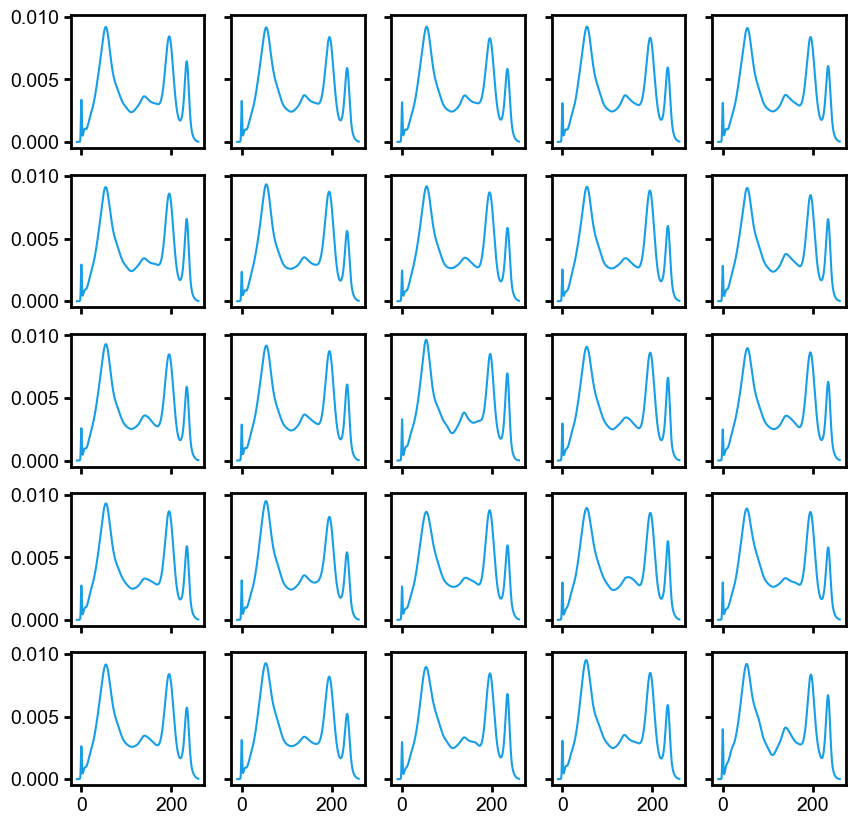

In [224]:
num = 5
# num = 28

# evaluate the probability at each pixel
y = np.linspace(-10, 260, 1000).reshape(-1, 1, 1, 1, 1)
mu, sigma, log_mix = pixel_cnn._pixel_cnn_flax.forward_pass(train_images[:1][..., None])
nll = - logsumexp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True) + pixel_cnn._pixel_cnn_flax.lognormal(y, mu, sigma), axis=-1)

mix = np.exp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True))

probs = np.exp(-nll[:, 0, :num, :num])
# probs = -nll[:, 0, :num, :num]

fig, ax = plt.subplots(num, num, figsize=(10, 10), sharex=True, sharey=True)
for i in range(num):
    for j in range(num):
        ax[i,j].plot(y.ravel(), probs[..., i, j])
        # ax[i,j].set_ylim(0, .01)


11.742797533827739
1.0
58.66489742102063
97.68927014378136


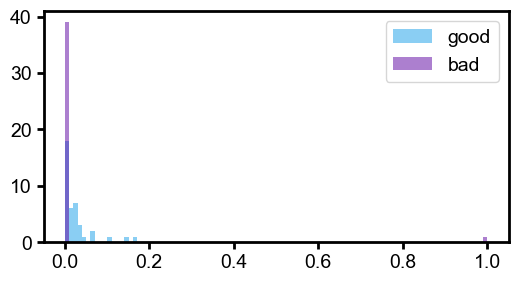

In [210]:
mix = np.exp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True))
assert np.allclose(mix.sum(-1), 1)

mix[0, 0, 3, :]
mu[0, 0, 3, :]
# log_sigma[0, 0, 2, :]

i, j = 1, 3

fig, ax = plt.subplots(1,1, figsize=(6,3))
_ = ax.hist(mix[0, 0, 0, :], bins=np.linspace(0,1,100), label='good', alpha=0.5)
ax.hist(mix[0, i, j, :], bins=np.linspace(0,1,100), label='bad', alpha=0.5)
ax.legend()

for k, l in [(0,0), (i,j)]:
    m = np.argmax(mix[0, k, l, :])
    print(sigma[0, k, l, m])

for k, l in [(0,0), (i,j)]:
    m = np.argmax(mix[0, k, l, :])
    print(mu[0, k, l, m])

## Visialize the gradients

In [191]:
from pixel_cnn import PixelCNNFlaxImpl
from jax import random
from jax import jit
from jax import numpy as jnp
from jax import value_and_grad
from flax.training import train_state, checkpoints
import optax


c_hidden = 64
num_mixture_components = 40
exmp_imgs = train_images[:10]
learning_rate=1e-2
seed = 5


model = PixelCNNFlaxImpl(c_hidden=c_hidden, num_mixture_components=num_mixture_components,
                                      train_data_max=exmp_imgs.max(), train_data_std=exmp_imgs.std(),
                                      preprocess_mean=exmp_imgs.mean(), preprocess_std=exmp_imgs.std())



def get_datasets(images, batch_size):
    """
    Use tensorflow datasets to make fast data pipelines
    """
    num_val_samples = 1000
    # add trailing channel dimension if necessary
    if images.ndim == 3:
        images = images[..., np.newaxis]
    elif images.shape[-1] != 1:
        raise ValueError("PixelCNN only supports single-channel images currently")
        

    # split images into train and validation
    val_images = images[:num_val_samples]
    train_images = images[num_val_samples:]

    # make tensorflow datasets
    train_ds = tf.data.Dataset.from_tensor_slices(train_images)
    val_ds = tf.data.Dataset.from_tensor_slices(val_images)

    train_ds = train_ds.repeat().shuffle(1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.shuffle(1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    return train_ds.as_numpy_iterator(), lambda : val_ds.as_numpy_iterator()


init_rng = random.PRNGKey(seed)
params = model.init(init_rng, exmp_imgs)
_, rng1, rng2 = random.split(init_rng, num=3)
# Initialize parameters for mixture density so that likelihood is reasonable for the given data, 
# but also with some random variation so it trains different components

# randomly in the data range
params['params']['mu_dense']['bias'] = jnp.ones_like(params['params']['mu_dense']['bias']) * random.uniform(rng1, params['params']['mu_dense']['bias'].shape, minval=exmp_imgs.min(), maxval=exmp_imgs.max())
# params['params']['mu_dense']['bias'] = jnp.ones_like(params['params']['mu_dense']['bias']) * exmp_imgs.mean()
params['params']['mu_dense']['kernel'] *= (exmp_imgs.mean() /  params['params']['mu_dense']['kernel'].size)
# TODO this is heuristically chosen

data_range = exmp_imgs.max() - exmp_imgs.min()
params['params']['sigma_dense']['bias'] = jnp.ones_like(
                    params['params']['sigma_dense']['bias']) * (
                            random.uniform(rng2, params['params']['sigma_dense']['bias'].shape, minval=1, maxval=5))
params['params']['sigma_dense']['kernel'] = params['params']['sigma_dense']['kernel'] * 0
                                    
# all equal
params['params']['mix_logit_dense']['kernel'] = np.ones_like(params['params']['mix_logit_dense']['kernel']) 
                                    



# Initialize model
init_rng = random.PRNGKey(seed)
params = model.init(init_rng, exmp_imgs)
_, rng1, rng2 = random.split(init_rng, num=3)
# Initialize parameters for mixture density so that likelihood is reasonable for the given data, 
# but also with some random variation so it trains different components

# randomly in the data range
params['params']['mu_dense']['bias'] = jnp.ones_like(params['params']['mu_dense']['bias']) * random.uniform(rng1, params['params']['mu_dense']['bias'].shape, minval=exmp_imgs.min(), maxval=exmp_imgs.max())
# params['params']['mu_dense']['bias'] = jnp.ones_like(params['params']['mu_dense']['bias']) * exmp_imgs.mean()
params['params']['mu_dense']['kernel'] *= (exmp_imgs.mean() /  params['params']['mu_dense']['kernel'].size)
# TODO this is heuristically chosen

data_range = exmp_imgs.max() - exmp_imgs.min()
params['params']['sigma_dense']['bias'] = jnp.ones_like(
                    params['params']['sigma_dense']['bias']) * (
                            random.uniform(rng2, params['params']['sigma_dense']['bias'].shape, minval=1, maxval=5))
params['params']['sigma_dense']['kernel'] = params['params']['sigma_dense']['kernel'] * 0
                                    
# all equal
params['params']['mix_logit_dense']['kernel'] = np.ones_like(params['params']['mix_logit_dense']['kernel']) 
                                    
state = train_state.TrainState(step=0,
                                    apply_fn=model.apply,
                                    params=params,
                                    tx=None,
                                    opt_state=None)

 

optimizer = optax.adam(learning_rate)
# Initialize training state
state = train_state.TrainState.create(apply_fn=state.apply_fn,
                                            params=state.params,
                                            tx=optimizer)



# @jit
def train_step(state, imgs):
    loss_fn = lambda params: state.apply_fn(params, imgs)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    # fig, ax = plt.subplots(1,1)
    # ax.imshow(grads['params']['sigma_dense']['kernel'])
    # raise ValueError()
    state = state.apply_gradients(grads=grads)
    return state, loss

def train_epoch(train_loader, steps_per_epoch, epoch):
    global state
    # Train model for one epoch, and log avg NLL
    avg_loss = 0
    for i in tqdm(range(steps_per_epoch), desc=f'Epoch{epoch}', leave=False):
        batch = next(train_loader)
        state, loss = train_step(state, batch)
        avg_loss += loss / steps_per_epoch


steps_per_epoch = 100

train_loader, val_loader = get_datasets(train_images, batch_size=4)

# eval_nll = 0
# Track best eval nll
best_eval_epoch = 0
for epoch_idx in range(20):
    train_epoch(train_loader, steps_per_epoch, epoch=epoch_idx)





KeyboardInterrupt: 